In [9]:
# Import libraries
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from datetime import datetime
import os
import sys

In [11]:
# Set project root for relative imports
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import updated PyMC-compatible functions
from src.oil_analysis import (
    load_and_preprocess_data,  
    research_events, 
    build_pymc_model,     
    run_mcmc, 
    #plot_price_and_returns,
    plot_change_point_posterior, 
    plot_parameter_comparison, 
    plot_model_fit
)

In [12]:
# Plotting setup
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style("whitegrid")


In [14]:
# Load and preprocess data
data_path = os.path.join(project_root, 'data', 'BrentOilPrices.csv')
oil_data = load_and_preprocess_data(data_path)

Data loaded successfully.


d:\tenx\Change_Point_Analysis_w10\src\oil_analysis.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)


Data preprocessed and log returns calculated.


In [15]:
# Load curated global events
events_df = research_events()
print(events_df)

# Prepare log returns for modeling
log_returns_series = oil_data['log_returns']

# Build Bayesian change point model
oil_model, tau = build_pymc_model(log_returns_series)  

# Run MCMC sampling
trace = run_mcmc(oil_model)

        Date                                              Event  \
0 2003-03-20                            US-led invasion of Iraq   
1 2008-09-15  Lehman Brothers collapse (Global Financial Cri...   
2 2014-11-27                     OPEC refuses to cut production   
3 2016-01-20                   Crude oil price hits 12-year low   
4 2020-03-08                      Saudi-Russia price war begins   
5 2022-02-24                             Russia invades Ukraine   

                                         Description  
0      Major conflict in a key oil-producing region.  
1  Triggered a major global recession, reducing o...  
2  OPEC shifts strategy to protect market share, ...  
3                 Market oversupply fears intensify.  
4  Saudi Arabia and Russia fail to agree on produ...  
5  Introduces significant geopolitical risk and s...  
PyMC model built successfully.


Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma_1, sigma_2]


d:\tenx\Change_Point_Analysis_w10\venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 92 seconds.


In [16]:
# Model summary
print("Model Summary:")
print(az.summary(trace, hdi_prob=0.95)) 


Model Summary:
             mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
tau      5389.551  20.908  5346.000   5422.000      0.636    0.423    1133.0   
mu_1        0.000   0.000    -0.000      0.001      0.000    0.000    8816.0   
mu_2       -0.000   0.000    -0.001      0.001      0.000    0.000    8273.0   
sigma_1     0.023   0.000     0.023      0.024      0.000    0.000    7287.0   
sigma_2     0.029   0.000     0.028      0.030      0.000    0.000    8685.0   

         ess_tail  r_hat  
tau        1347.0    1.0  
mu_1       6465.0    1.0  
mu_2       5962.0    1.0  
sigma_1    5690.0    1.0  
sigma_2    6389.0    1.0  


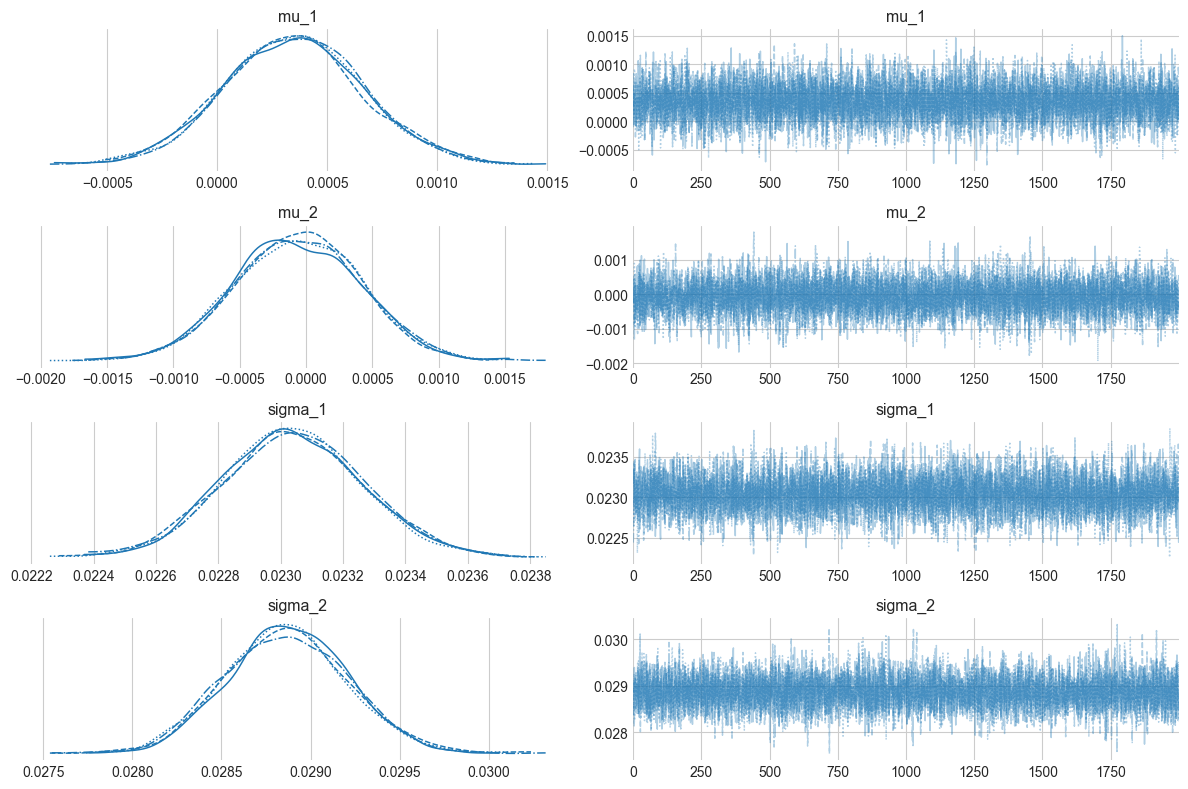

In [17]:
# Trace plots
az.plot_trace(trace, var_names=['mu_1', 'mu_2', 'sigma_1', 'sigma_2'])  
plt.tight_layout()
plt.show()

d:\tenx\Change_Point_Analysis_w10\src\oil_analysis.py:104: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  plt.ylabel('Price')
d:\tenx\Change_Point_Analysis_w10\src\oil_analysis.py:105: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  


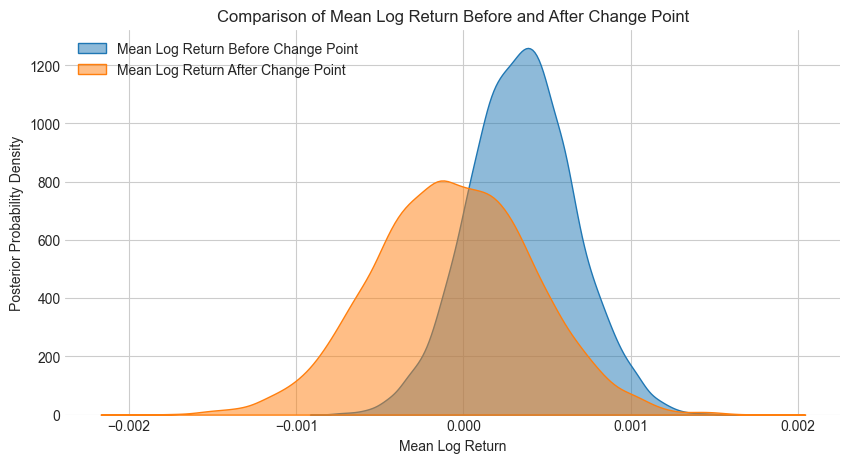

95% HDI for Mean Log Return Before: [-0.00026188  0.00098773]
95% HDI for Mean Log Return After: [-0.00098463  0.00085853]


d:\tenx\Change_Point_Analysis_w10\src\oil_analysis.py:104: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  plt.ylabel('Price')
d:\tenx\Change_Point_Analysis_w10\src\oil_analysis.py:105: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  


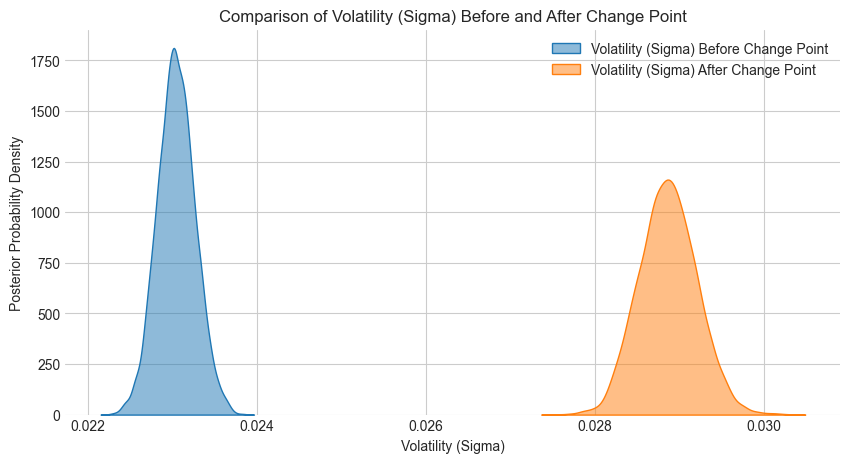

95% HDI for Volatility (Sigma) Before: [0.02261744 0.02350069]
95% HDI for Volatility (Sigma) After: [0.02821015 0.02952923]


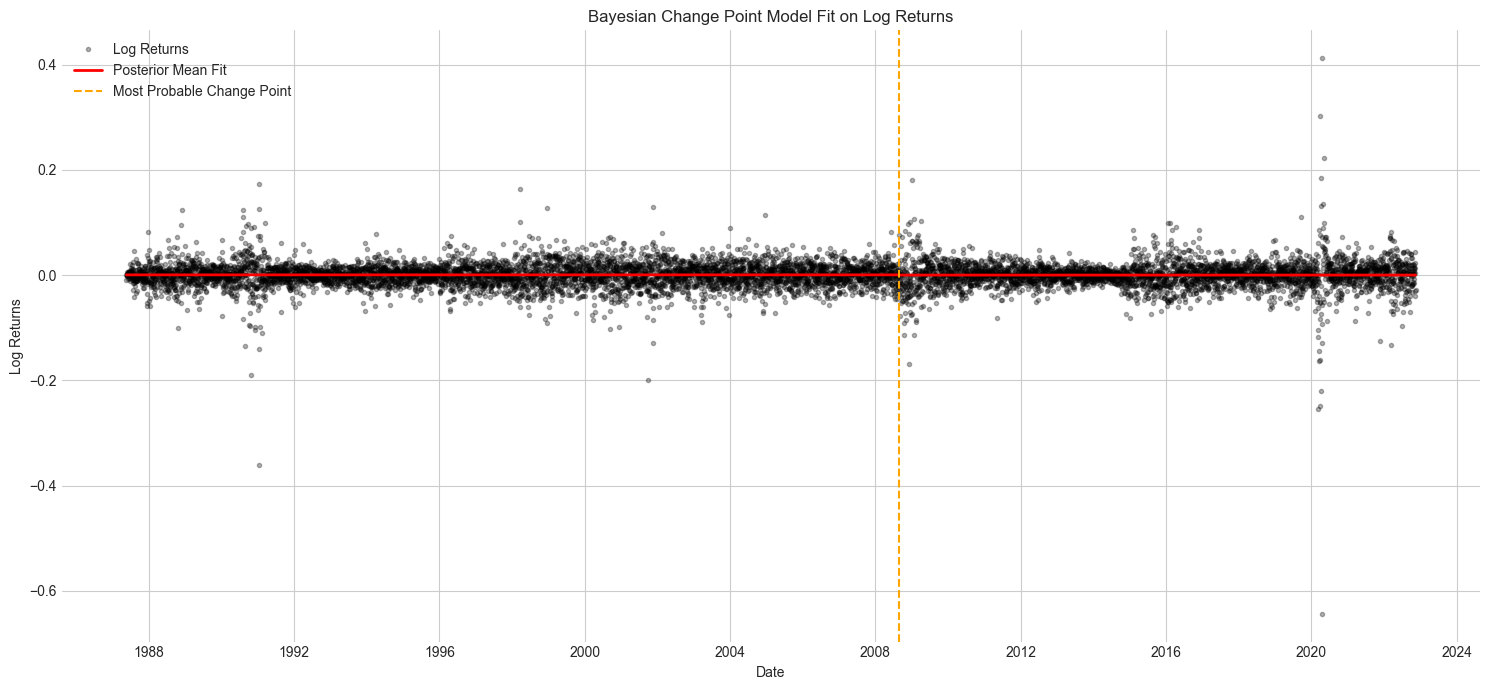

In [19]:
# # Plot posterior of change point
# plot_change_point_posterior(trace, oil_data.index)

# Compare means (pre vs post change)
plot_parameter_comparison(trace, 'mu_1', 'mu_2', 'Mean Log Return')

# Compare volatilities (pre vs post change)
plot_parameter_comparison(trace, 'sigma_1', 'sigma_2', 'Volatility (Sigma)')

# Plot model fit
plot_model_fit(log_returns_series, trace, oil_data.index)